# Text Classification with GloVe Embeddings and LSTM Networks
This notebook demonstrates how to perform text classification using GloVe embeddings and LSTM networks. The goal is to classify movie reviews from the IMDB dataset as positive or negative.

# Load Necessary Libraries
First, we need to import the required libraries.

In [1]:
# general libraries
import re
import os
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from scipy import spatial
from google.colab import files

# prevent warning
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# dimensionality reduction libraries
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# ML models and metrics
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# DL models
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nlp libraries
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download("wordnet")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Download glove Embedding
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

f = open('/tmp/glove/glove.6B.100d.txt')

glove_embedding = {}

for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype="float32")
    glove_embedding[word] = vec
f.close()

#Function to Calculate Closeness of Word Embeddings


In [ ]:
# Define a function to find the closest words in the embedding space using Euclidean distance.
def find_closest_embeddings(embedding):
    return sorted(glove_embedding.keys(), key=lambda word: spatial.distance.euclidean(glove_embedding[word], embedding))

# Find the closest embeddings for the vector representation of queen - woman + man, which typically results in "king".
find_closest_embeddings(glove_embedding['queen']-glove_embedding['woman']+glove_embedding['man'])[:3]

['queen', 'king', 'prince']

#Create Separate Lists for Words and Vectors


In [ ]:
# Create separate lists for the words and their corresponding vectors from the GloVe embeddings.
glove_words = list(glove_embedding.keys())[300:2500]
glove_vectors = list(glove_embedding.values())[300:2500]

# Make a dictionary includes above words as keys and their embedding vector as values
glove_embedding = {glove_words[i]:glove_vectors[i] for i in range(len(glove_words))}

#K-Means Clustering on Word Embeddings


In [ ]:
# A k-means clustering method on word embeddings to cluster them into 15 categories
kmeans = KMeans(n_clusters=15)
kmeans.fit(glove_vectors)
labels = kmeans.labels_

#PCA to Reduce GloVe Vectors to 3D & 2D


In [ ]:
# A PCA to reduce glove vectors to 3D
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(glove_vectors)

# A PCA to reduce glove vectors to 2D
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(glove_vectors)

#Plot 3D Scatter Plot with Text Annotations
Create a 3D scatter plot of the PCA-reduced vectors and add text annotations for each point to visualize the words in 3D space.

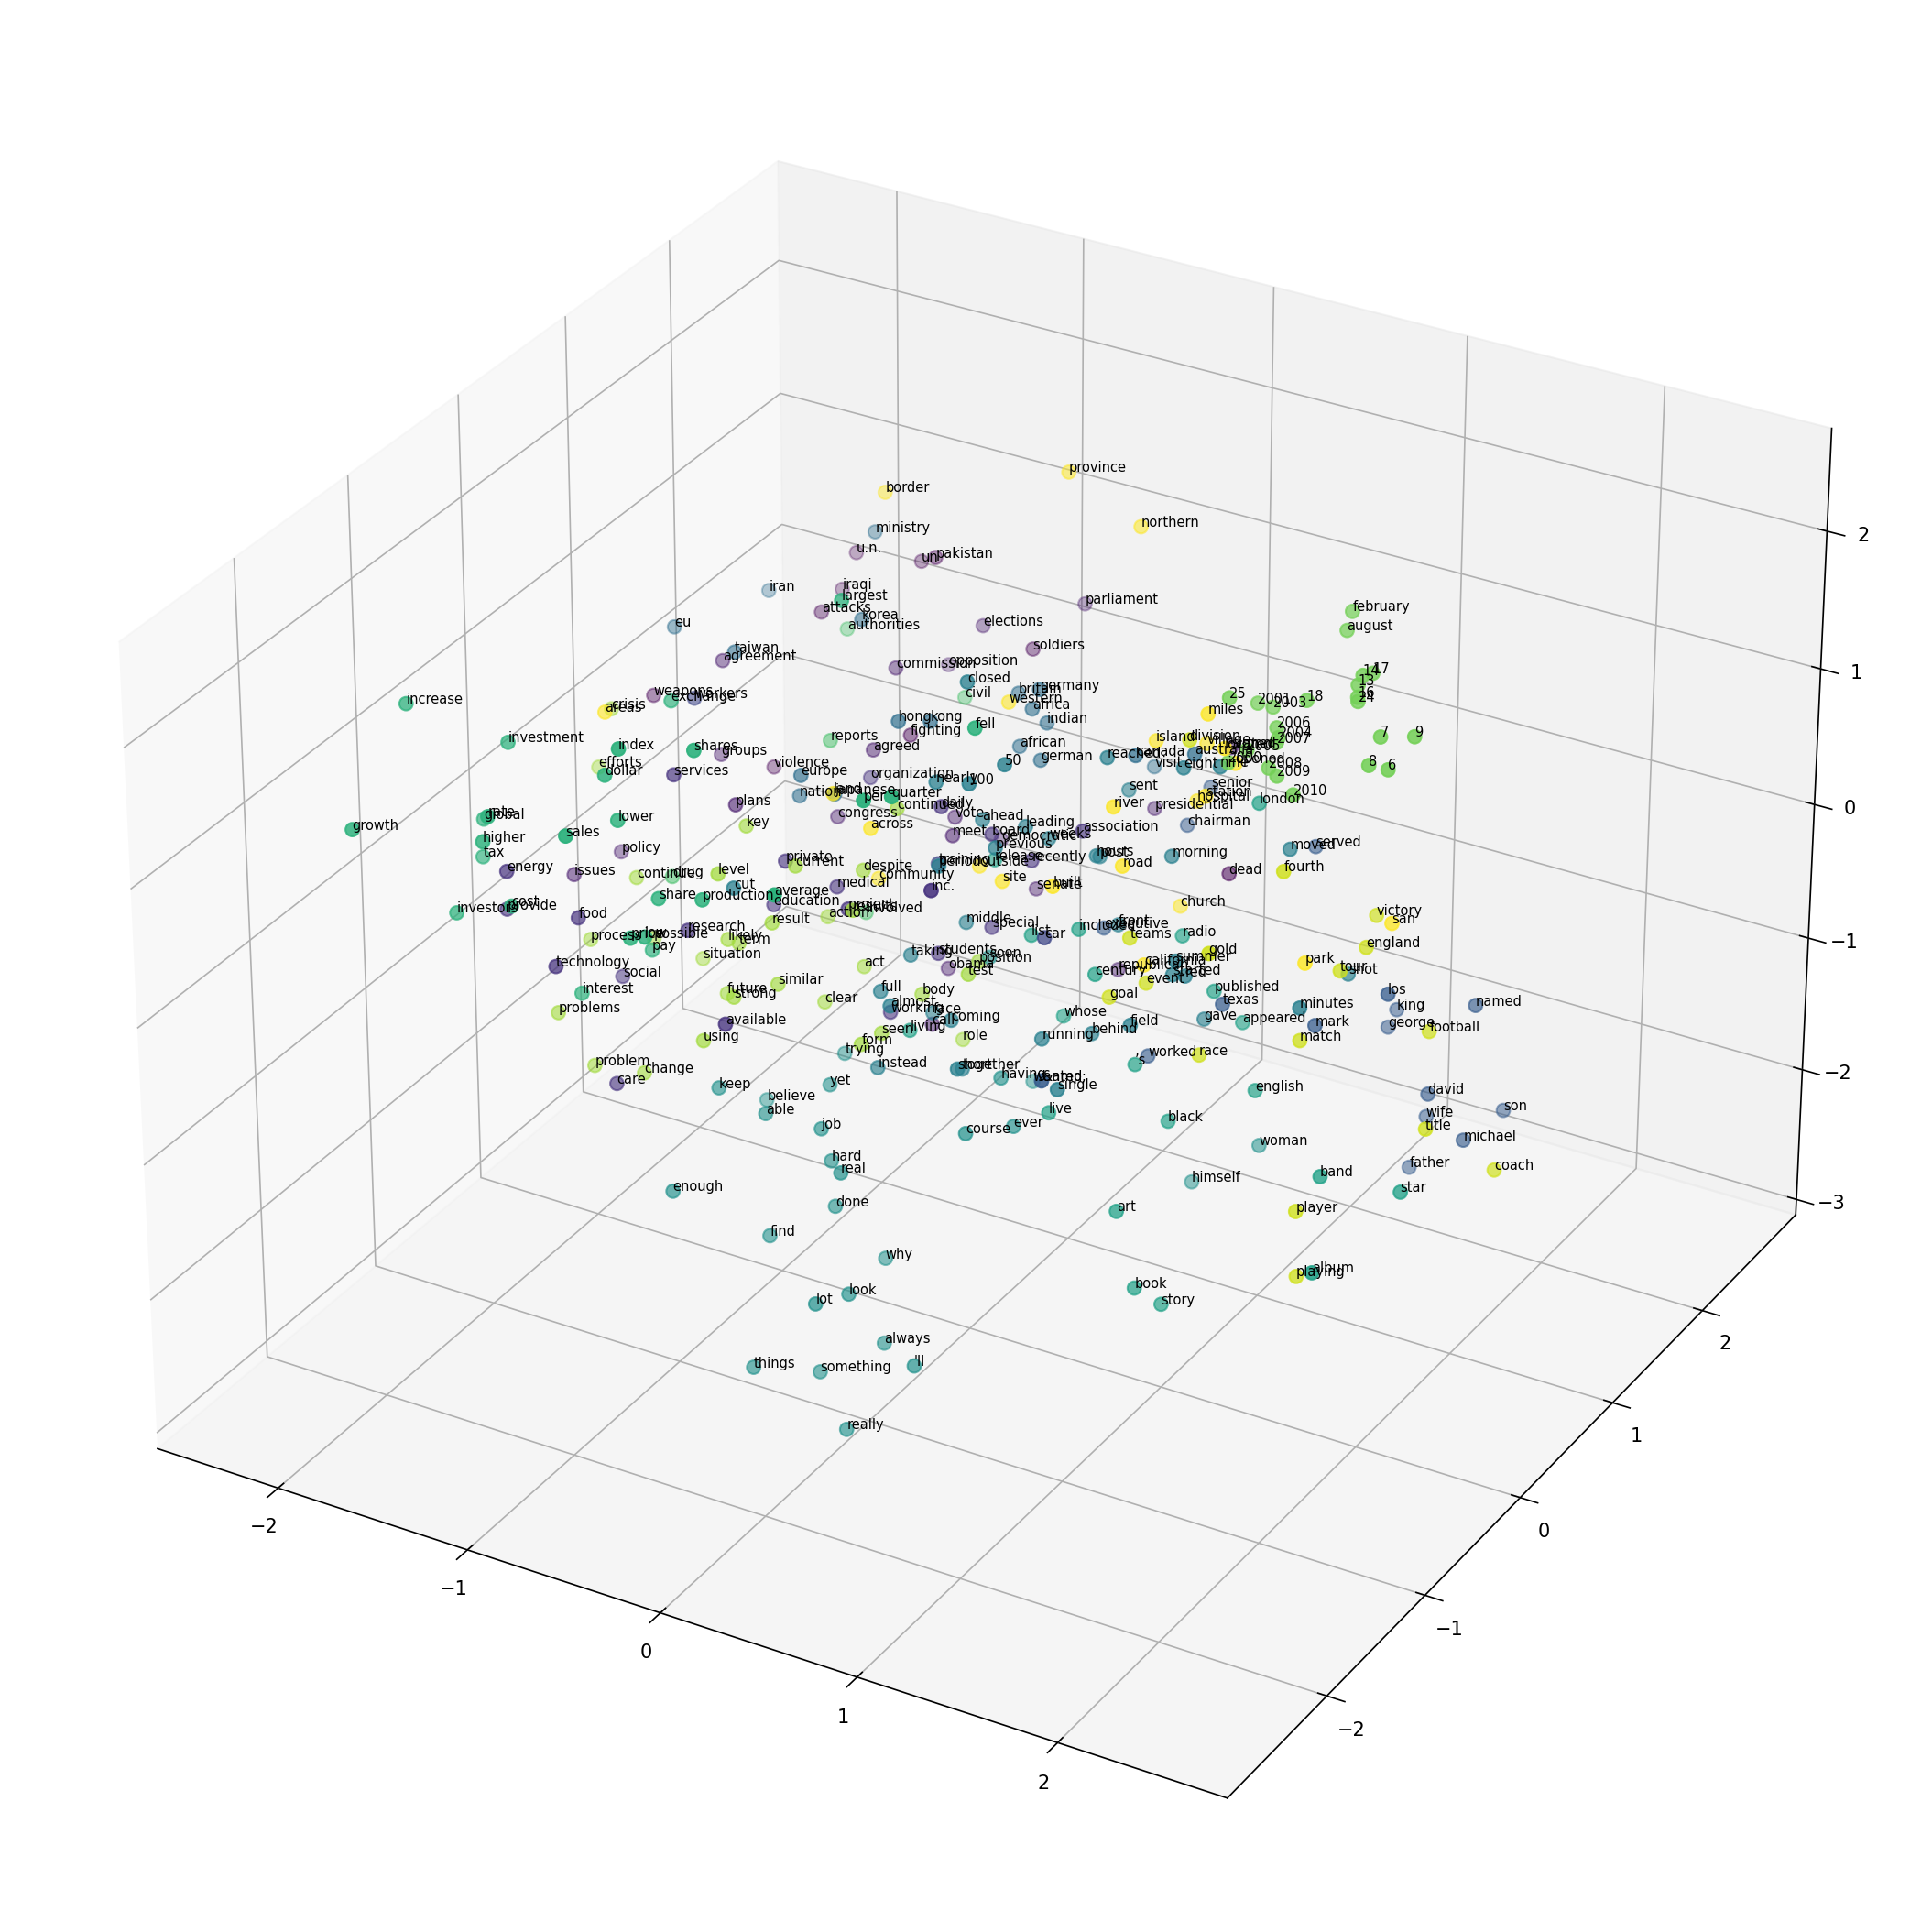

In [ ]:
# Extracting specific slices of the 3D vectors and corresponding labels and words for plotting
x=vectors_3d[200:500, 0]
y=vectors_3d[200:500, 1]
z=vectors_3d[200:500, 2]
colors = labels[200:500]
words = glove_words[200:500]

# Create the plot with specified size and resolution
fig = plt.figure(figsize=(18, 18), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color coding based on labels
sc = ax.scatter(x, y, z, c=colors, s=50)

# Add text annotations for each point in the scatter plot
for i, word in enumerate(words):
    ax.text(x[i], y[i], z[i], word, fontsize=7)

plt.show()

#Plot 2D Scatter Plot with Text Annotations
Create a 2D scatter plot of the PCA-reduced vectors and add text annotations for each point to visualize the words in 2D space.

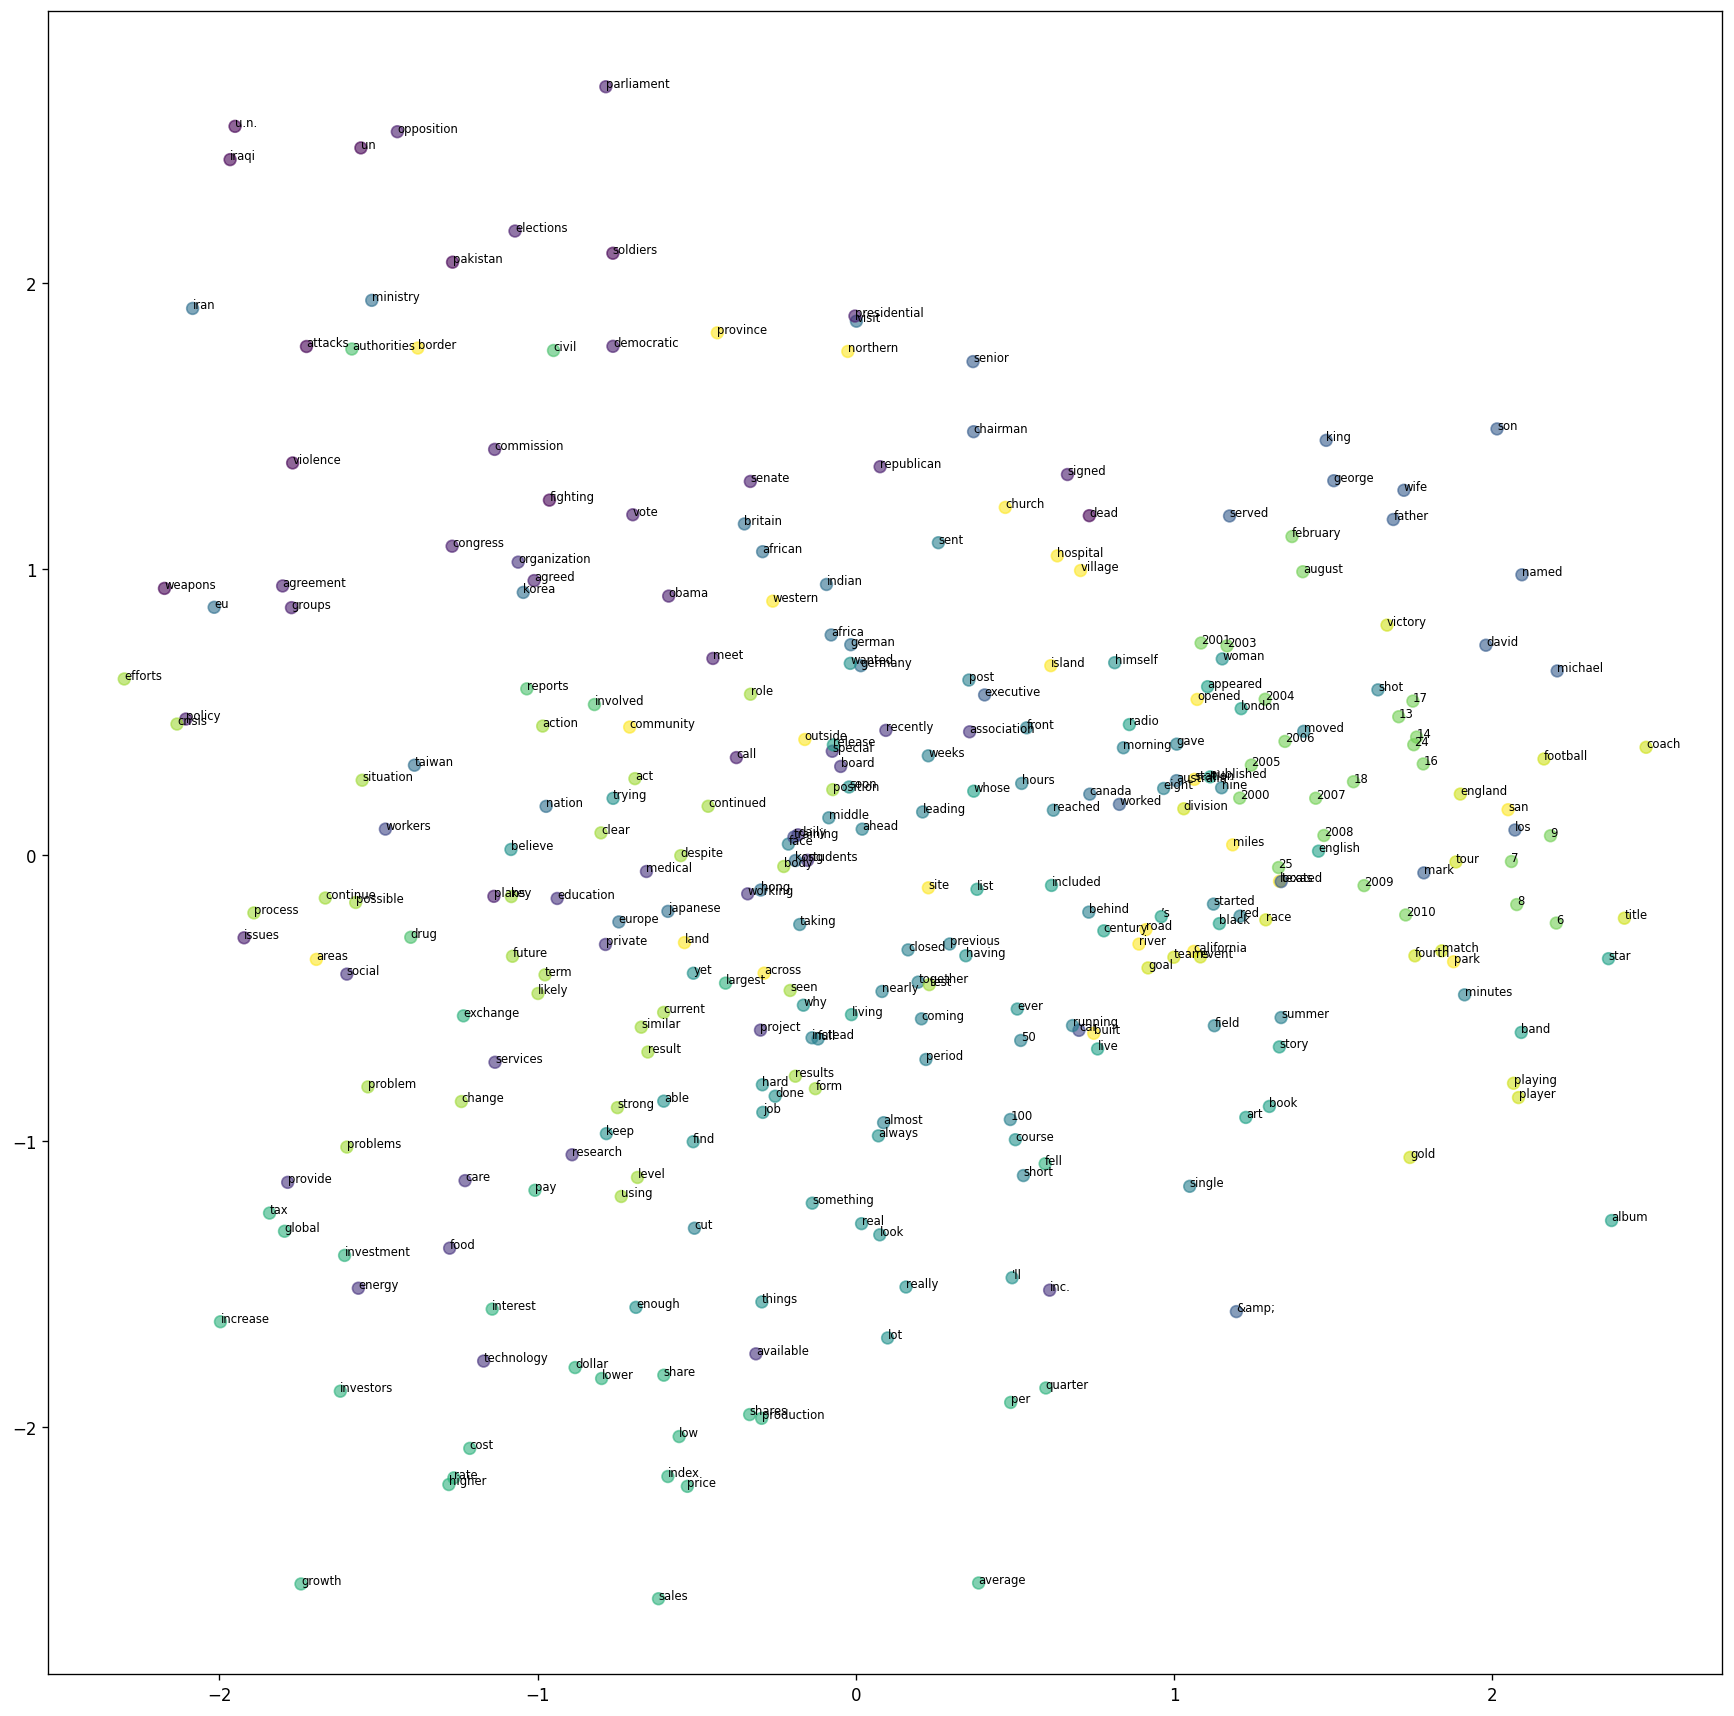

In [ ]:
# Extracting specific slices of the 2D vectors and corresponding labels and words for plotting
x=vectors_2d[200:500, 0]
y=vectors_2d[200:500, 1]
colors = labels[200:500]
words = glove_words[200:500]

# Create the plot with specified size and resolution
fig = plt.figure(figsize=(18, 18), dpi=120)
ax = fig.add_subplot(111)

# Scatter plot with color coding based on labels
sc = ax.scatter(x, y, c=colors, s=50, alpha=0.6)

# Add text annotations
for i, word in enumerate(words):
    ax.text(x[i], y[i], word, fontsize=7)

plt.show()

#Visualize Specific Words in 3D


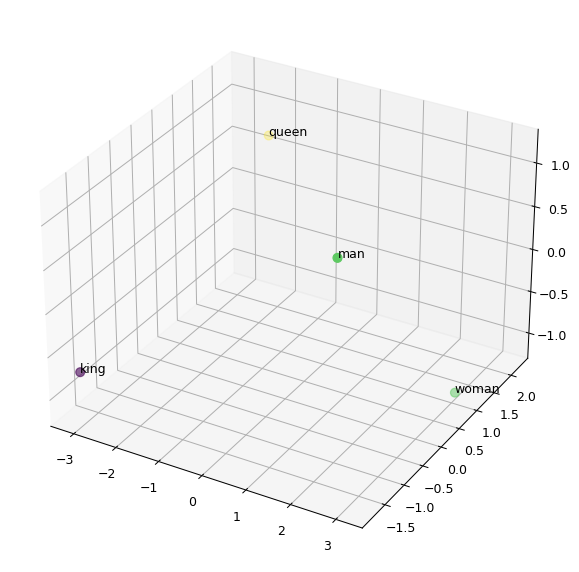

In [ ]:
# Define a list of words to visualize
words = ["man", "king", "woman", "queen"]

# Extract the corresponding vectors for these words from the GloVe embeddings
vectors = [glove_embedding[i] for i in words]

# Generate new labels for the selected words
new_labels = [labels[i] for i in range(len(glove_words)) if glove_words[i] in words]

# Perform PCA to reduce the dimensionality of the vectors to 3 components
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

# Create a plot with specified size and resolution
fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D vectors with color coding based on new labels
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], s=50, c=new_labels)

# Add text annotations for each point in the scatter plot
for i, word in enumerate(words):
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], word, fontsize=10)

plt.show()

#Visualize Specific Words in 2D Using t-SNE


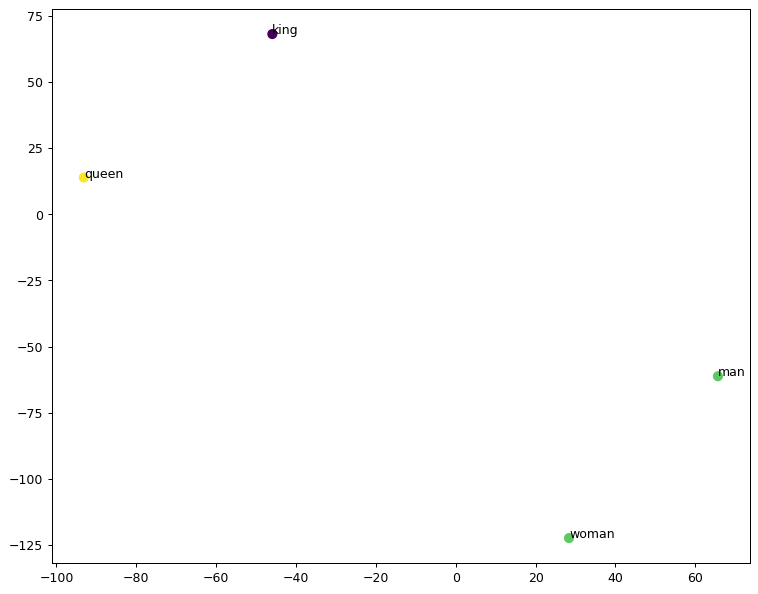

In [ ]:
# Define a list of words to visualize
words = ["man", "king", "woman", "queen"]

# Extract the corresponding vectors for these words from the GloVe embeddings and convert to numpy array
vectors = np.array([glove_embedding[i] for i in words])

# Generate new labels for the selected words
new_labels = [labels[i] for i in range(len(glove_words)) if glove_words[i] in words]

# Perform t-SNE to reduce the dimensionality of the vectors to 2 components
tsne = TSNE(n_components=2, perplexity=2)
vectors_2d = tsne.fit_transform(vectors)

# Create a plot with specified size and resolution
fig = plt.figure(figsize=(10,8), dpi=90)
ax = fig.add_subplot(111)

# Scatter plot of the 2D vectors with color coding based on new labels
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=50, c=new_labels)

# Add text annotations for each point in the scatter plot
for i, word in enumerate(words):
    ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=10)

plt.show()

#Visualize Embedding Vectors
We visualize the embedding vectors using PCA (Principal Component Analysis) to reduce the dimensionality to 2D space.

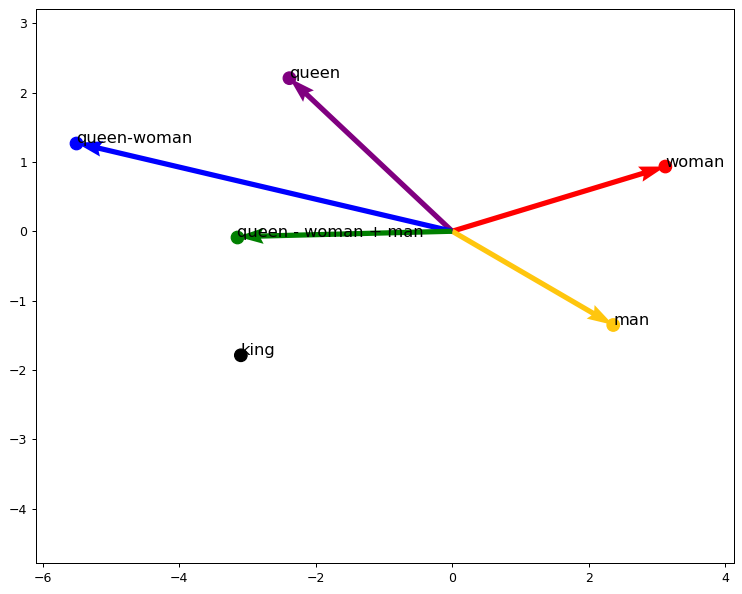

In [ ]:
# Define a list of words to visualize
words = ["man", "king", "woman", "queen"]

# Extract the corresponding vectors for these words from the GloVe embeddings and convert to numpy array
vectors = np.array([glove_embedding[i] for i in words])

# Define new labels with specific colors for each word
new_labels = ['#ffc60e', 'black', 'red', 'purple']

# Perform PCA to reduce the dimensionality of the vectors to 2 components
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a plot with specified size and resolution
fig = plt.figure(figsize=(10, 8), dpi=90)
ax = fig.add_subplot(111)

# Scatter plot of the 2D vectors with color coding based on new labels
ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=100, c=new_labels)

# Add text annotations for each point in the scatter plot
for i, word in enumerate(words):
    ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=13)

# Create a dictionary to store the 2D points for each word
points = {word: vectors_2d[i] for i, word in enumerate(words)}
queen_point = points['queen']
woman_point = points['woman']
man_point = points['man']

# Calculate the vector differences and additions
queen_woman = queen_point - woman_point
plus_man = queen_woman + man_point

# Plot the vectors using quiver with dotted lines
ax.quiver(0, 0, queen_point[0], queen_point[1], angles='xy', scale_units='xy', scale=1, color='purple', linestyle='dotted')
ax.quiver(0, 0, woman_point[0], woman_point[1], angles='xy', scale_units='xy', scale=1, color='red', linestyle='dotted')
ax.quiver(0, 0, man_point[0], man_point[1], angles='xy', scale_units='xy', scale=1, color='#ffc60e', linestyle='dotted')
ax.quiver(0, 0, queen_woman[0], queen_woman[1], angles='xy', scale_units='xy', scale=1, color='blue', linestyle='dotted')
ax.quiver(0, 0, plus_man[0], plus_man[1], angles='xy', scale_units='xy', scale=1, color='green', linestyle='dotted')

# Scatter and annotate the calculated points
ax.scatter(plus_man[0], plus_man[1], s=100, c='green')
ax.text(plus_man[0], plus_man[1], 'queen - woman + man', fontsize=13)
ax.scatter(queen_woman[0], queen_woman[1], s=100, c='blue')
ax.text(queen_woman[0], queen_woman[1], 'queen-woman', fontsize=13)

# Set the limits for the plot axes
ax.set_xlim(min(vectors_2d[:, 0]) - 3, max(vectors_2d[:, 0]) + 1)
ax.set_ylim(min(vectors_2d[:, 1]) - 3, max(vectors_2d[:, 1]) + 1)

plt.show()


## Explanation of Output

In this section, we visualize the selected word embeddings in 2D space using PCA and plot vector operations like `queen - woman + man`. The output of this visualization provides several insights:

1. **Word Embedding Relationships**:
   - The 2D scatter plot displays the positions of the selected words (`man`, `king`, `woman`, `queen`) in a reduced 2D space. This reduction preserves as much variance as possible, allowing us to see how these word vectors relate to each other in a simpler form.

2. **Vector Arithmetic**:
   - The vectors corresponding to the words are displayed as points in the 2D space. By performing vector arithmetic (`queen - woman + man`), we visualize the result of this operation in the context of the embeddings.
   - In the plot, dotted lines represent the vectors and their operations:
     - `queen - woman` is represented by a blue dotted line.
     - `queen - woman + man` is represented by a green dotted line.
   - These operations demonstrate how word embeddings can capture semantic relationships. For example, the result of `queen - woman + man` is close to `king`, showing that the model has learned gender relationships.

3. **Annotations**:
   - Each point in the scatter plot is annotated with the corresponding word, making it easy to identify which point represents which word.
   - Additional annotations like `queen - woman + man` help illustrate the result of the vector arithmetic directly on the plot.

4. **Color Coding**:
   - Each word is color-coded to differentiate them visually. For instance, `queen` is purple, `woman` is red, `man` is yellow, and the result of the vector operation is green.

5. **Quiver Plots**:
   - The quiver plots (arrows) represent the direction and magnitude of the vectors involved in the operations. They help visualize the relationship between the original vectors and the result of their arithmetic operations.

Overall, this visualization helps understand how word embeddings represent semantic meanings and relationships between words through geometric transformations. It shows the power of word embeddings in capturing complex relationships and how PCA can simplify high-dimensional data for easier interpretation.


# Downloading Datasets for using the Embedding in practice

In [2]:
# request to kaggle
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# download dataset
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 70% 18.0M/25.7M [00:00<00:00, 185MB/s]
100% 25.7M/25.7M [00:00<00:00, 206MB/s]


In [3]:
# unzipping downloaded dataset
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


# Load the IMDB Dataset
Next, we load the IMDB dataset and convert the sentiment labels to binary values (1 for positive, 0 for negative).

In [4]:
# Load the IMDB dataset from a CSV file
imdb = pd.read_csv('IMDB Dataset.csv')

# Convert the sentiment column to binary values: 1 for positive, 0 for negative
imdb['sentiment'] = [1 if i == 'positive' else 0 for i in imdb['sentiment']]

# Display a random sample of 5 rows from the dataframe
imdb.sample(5)

,review,sentiment
15894,Being a person who does not usually enjoy boxi...,1
17351,"Honestly before I watched this movie, I had he...",0
24096,I love movies. I love independent efforts and ...,0
30059,Kudos to director and cast for such a realisti...,1
11672,"> What a dud. It began with some promise, then...",0


# Visualize the Sentiment Distribution
We visualize the distribution of sentiments in the dataset using a count plot.

This helps us understand the balance of positive and negative reviews.


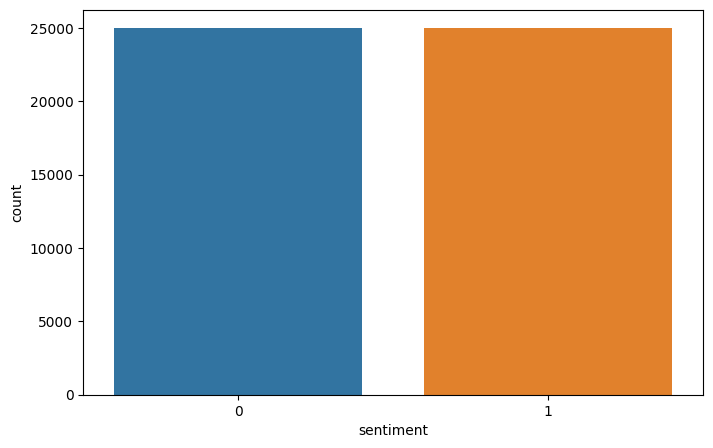

In [ ]:
# Create a figure with specified size
plt.figure(figsize=(8,5))

# Create a count plot for the 'sentiment' column with hue based on 'sentiment'
sns.countplot(data=imdb, x='sentiment', hue='sentiment', dodge=False)

# Display the plot
plt.show()

# Define Text Preprocessing Functions
We define functions to normalize, tokenize, remove stop words, and lemmatize the text data.

These functions help clean and prepare the text data for modeling.



In [7]:
# Load the list of stopwords
stop_lst = stopwords.words('english')

# Function to normalize the sentence
def normalize(sentence):
    sentence = re.sub('^http', ' ', sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = str(sentence).lower()
    return sentence

# Function to tokenize the sentence
def tokenize(sentence):
    sentence = word_tokenize(sentence)
    sentence = [token for token in sentence if len(token) > 2]
    return sentence

# Function to remove stop words from the sentence
def stop_words(sentence):
    sentence = [token for token in sentence if token not in stop_lst]
    return sentence

# Function to lemmatize the tokens in the sentence
def lemmatize(sentence):
    sentence = [WordNetLemmatizer().lemmatize(token) for token in sentence]
    return sentence

In [8]:
imdb['review'] = imdb['review'].progress_apply(normalize)
imdb['review'] = imdb['review'].progress_apply(tokenize)
imdb['review'] = imdb['review'].progress_apply(stop_words)
imdb['review'] = imdb['review'].progress_apply(lemmatize)

100%|██████████| 50000/50000 [00:30<00:00, 1645.32it/s]


# Extract GloVe Embeddings
We extract the pre-trained GloVe embeddings from a zip file and store them in a dictionary.

These embeddings will be used to represent words in a vector space.



In [ ]:
# Extract the GloVe embeddings from the zip file
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

# Open the extracted GloVe file
with open('/tmp/glove/glove.6B.100d.txt', 'r') as f:
    glove_embedding = {}

    # Read each line in the file and parse the word and its vector
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype="float32")
        glove_embedding[word] = vec

#Split the Data into Training and Test Sets
We split the dataset into training and test sets.

This step ensures that we have separate data for training the model and evaluating its performance.


In [10]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(imdb['review'], imdb['sentiment'], random_state=12)

# Initialize an empty set to store unique words
unique_words = set()

# Tokenize the sentence and add each word to the set of unique words
for sent in X_train:
  unique_words.add(word for word in sent)

# Define the maximum length of sequences
maxlen = 100

# Determine the vocabulary size based on the number of unique words
vocab_size = len(unique_words)

#Convert Text Data to Sequences
Convert the text data to sequences of integers using the fitted tokenizer.


In [ ]:
#Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

#Create the Embedding Matrix
We create an embedding matrix for the words in the IMDB dataset using the GloVe embeddings.

This matrix will be used in the embedding layer of our neural network.



In [ ]:
word_index = tokenizer.word_index
embedding_dim = 100

# Create an embedding matrix for the words in the IMDb dataset
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#Define a Function to Get Average Embeddings
We define a function to get the average embedding for each sequence.

This helps in reducing the dimensionality and capturing the essence of each sentence.

In [ ]:
def get_average_embedding(sequences, embedding_matrix):
    embeddings = []
    for seq in sequences:
        # Filter out words not in the embedding matrix and zero padding
        embedded_seq = [embedding_matrix[word] for word in seq if word < embedding_matrix.shape[0] and word != 0]
        if embedded_seq:
            # Calculate the average embedding for the sequence
            avg_embedding = np.mean(embedded_seq, axis=0)
        else:
            # If no valid words, use a zero vector of the same dimension as embeddings
            avg_embedding = np.zeros(embedding_matrix.shape[1])
        embeddings.append(avg_embedding)
    return np.array(embeddings)

# Assuming X_train_padded and X_test_padded are the tokenized and padded versions of X_train and X_test
X_train_embed = get_average_embedding(X_train_padded, embedding_matrix)
X_test_embed = get_average_embedding(X_test_padded, embedding_matrix)

#Train a K-Nearest Neighbors Classifier
We train a K-Nearest Neighbors (KNN) classifier on the training data.

This is a simple baseline model to compare against our neural network.

In [ ]:
# Initialize the K-Nearest Neighbors classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier on the training data
knn.fit(X_train_embed, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test_embed)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.73064


#Build and Train a Sequential Model
We build and train a neural network model using Keras.

The model includes embedding layers, bidirectional LSTM layers, dense layers, and dropout layers to prevent overfitting.

In [ ]:
# Define the Sequential model
model = Sequential()

# Add an embedding layer using the pre-trained embedding matrix
model.add(layers.Embedding(input_dim=embedding_matrix.shape[0],
                           output_dim=embedding_matrix.shape[1],
                           input_length=100,
                           weights=[embedding_matrix],
                           trainable=False))

model.add(layers.Bidirectional(layers.LSTM(128, recurrent_dropout=0.1))) # Add a bidirectional LSTM layer with 128 units
model.add(layers.Dense(128))
model.add(layers.Reshape((1, 128))) # Reshape layer to match the input shape of the next LSTM layer
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.1))) # Add a bidirectional LSTM layer with 256 units
model.add(layers.Dense(64))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation='sigmoid')) # The output layer with a sigmoid activation function


# Compile the model using binary crossentropy loss and the Adam optimizer
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Fit the model on the training data with validation on the test data
history = model.fit(X_train_padded, y_train, batch_size=100, epochs=5, validation_data=(X_test_padded, y_test))

Epoch 1/5
375/375 [==============================] - 399s 1s/step - loss: 0.4752 - accuracy: 0.7764 - val_loss: 0.4063 - val_accuracy: 0.8223
Epoch 2/5
375/375 [==============================] - 397s 1s/step - loss: 0.3873 - accuracy: 0.8297 - val_loss: 0.3759 - val_accuracy: 0.8365
Epoch 3/5
375/375 [==============================] - 403s 1s/step - loss: 0.3455 - accuracy: 0.8526 - val_loss: 0.3429 - val_accuracy: 0.8530
Epoch 4/5
375/375 [==============================] - 398s 1s/step - loss: 0.3106 - accuracy: 0.8685 - val_loss: 0.3291 - val_accuracy: 0.8592
Epoch 5/5
375/375 [==============================] - 397s 1s/step - loss: 0.2851 - accuracy: 0.8798 - val_loss: 0.3314 - val_accuracy: 0.8614
